In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from train import *
from utils import utils

#### 1. Download sample data, uncomment and run this if you have not already downloaded it

In [ ]:
# !wget -P data/dragon/ https://soap.cs.princeton.edu/demo/frame_bundle.npz
# !wget -P data/ https://soap.cs.princeton.edu/shade_map.npy

#### 2. Start training
On a single a100 the training below should finish running in ~8mins.  
You can point tensorboard to the `lightning_logs` directory to monitor training.

In [ ]:
# only run to 50 epochs to save time, remove the flag to run for default 100 epochs
!python3 train.py --name dragon-test --bundle_path data/dragon/frame_bundle.npz --max_epochs 50

#### 3. Load the model from Disk

In [2]:
model = BundleMLP.load_from_checkpoint("checkpoints/dragon-test/last.ckpt", device="cuda")

In [3]:
# move model components to GPU
model = model.eval()
model = model.to('cuda')
model.rgb_volume = model.rgb_volume.to('cuda')
model.processed_rgb_volume = model.processed_rgb_volume.to('cuda')
model.model_rotation = model.model_rotation.to('cuda')
model.model_translation = model.model_translation.to('cuda')
model.reference_intrinsics = model.reference_intrinsics.to('cuda')
model.model_rotation.reference_rotation = model.model_rotation.reference_rotation.to('cuda')

# use all encoding levels for inference
model.mask = torch.ones_like(model.mask)

#### 4. Generate outputs

In [4]:
rgb, rgb_raw, rgb_processed, depth, depth_img = model.generate_outputs(frame=0, height=1920, width=1440, u_lims=[0.025,0.975], v_lims=[0.025,0.975])

Outputs:
1. `rgb` : color values I(u,v) output by implicit image model
2. `rgb_raw` : corresponding sampled values from bayer RAW volume
3. `rgb_processed` : corresponding sampled values from processed RGB volume
4. `depth` : depth values D(u,v) from shakes-on-a-plane implicit depth model
5. `depth_img` : same as `depth` but with colormap applied for tensorboard visualization

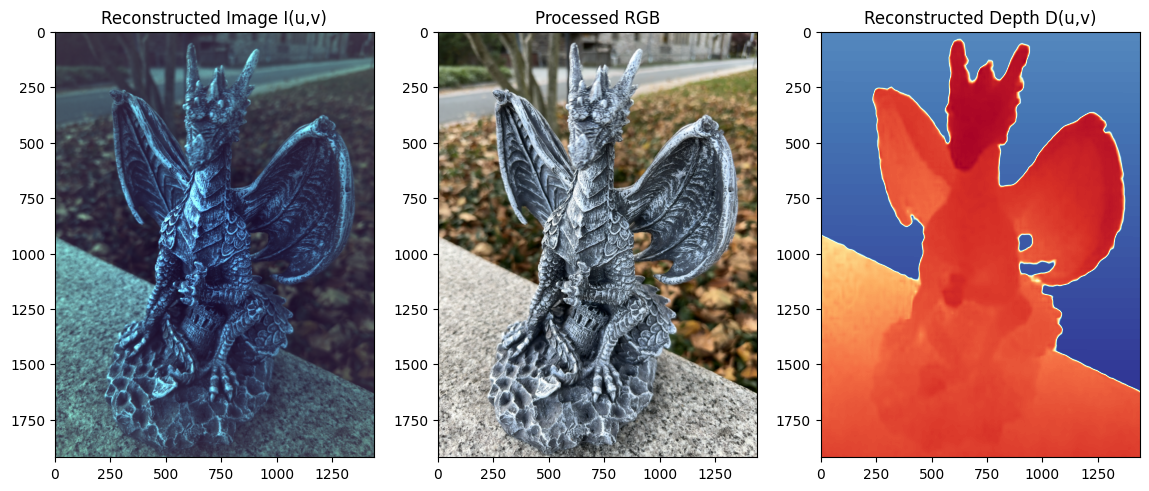

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 8))
axes[0].imshow((2 * rgb.permute(1,2,0).cpu()).clip(0,1)) # increase brightness
axes[0].set_title("Reconstructed Image I(u,v)")
axes[1].imshow(rgb_processed.permute(1,2,0).cpu())
axes[1].set_title("Processed RGB")
axes[2].imshow(depth.cpu(), cmap="RdYlBu")
axes[2].set_title("Reconstructed Depth D(u,v)")
plt.show()